<a href="https://colab.research.google.com/github/anoopmanikantas/Time-Series-analysis-of-Satellite-data-Feature-extractions-on-Transitions/blob/main/Satellite_Data_Processing_Local_runtime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is to connect colab UI to local runtime jupyter backend

Importing required libraries

In [1]:
#@title Imports
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import matplotlib.pyplot as plt
import os
import numpy as np
import tifffile as tiff
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tqdm import tqdm
from tensorflow.keras.utils import Sequence
import math
import gc

In [2]:
#@title Seed = 1024
np.random.seed(1024)

Copying data from drive to colab local storage for faster access during training

In [48]:
#@title Constants
MAIN_DIR = './data/'
N_BANDS = 8
N_CLASSES = 5  # buildings, roads, trees, crops and water
CLASS_WEIGHTS = [0.2, 0.3, 0.1, 0.1, 0.3]
N_EPOCHS = 150
UPCONV = True
PATCH_SZ = 32
BATCH_SIZE = 60
STRIDE = 25
MODEL_NAME = "/unet_weights.hdf5"
TRAIN_SZ = 0.75
TEST_IMAGE = 'test'
TEST_IMAGE1 = '22'

Visualization


In [4]:
#@title Function to visualize a 16 bit image (by converting to 8 bit)
def stretch_8bit(bands, lower_percent=2, higher_percent=98):
    out = np.zeros_like(bands)
    for i in range(3):
        a = 0 
        b = 255 
        c = np.percentile(bands[:,:,i], lower_percent)
        d = np.percentile(bands[:,:,i], higher_percent)        
        t = a + (bands[:,:,i] - c) * (b - a) / (d - c)    
        t[t<a] = a
        t[t>b] = b
        out[:,:,i] =t
    return out.astype(np.uint8)    
def visualize(filename):
    img = tiff.imread(filename)
    img = np.rollaxis(img, 0, 3)
    img1 = np.zeros((img.shape[0],img.shape[1],3))
    img1[:,:,0] = img[:,:,4] #red
    img1[:,:,1] = img[:,:,2] #green
    img1[:,:,2] = img[:,:,1] #blue
    return stretch_8bit(img1)
# img = visualize(input_raster)
# plt.imshow(img)

In [5]:
#@title Visualization (uncomment to see the results)
# fig,ax = plt.subplots(24,6,figsize=(50,200))
# masks = ['Buildings', 'Roads', 'Trees', 'Crops', 'Water']
# ax[0][0].set_title('maps', fontsize=25)
# for mask in range(5):
#     ax[0][mask+1].set_title(masks[mask], fontsize=25)
# for img_id in range(24):
#   input_raster = MAIN_DIR+'mband/{}.tif'.format(str(img_id+1).zfill(2))
#   mask_raster = MAIN_DIR+'gt_mband/{}.tif'.format(str(img_id+1).zfill(2))
#   img_8_bit = visualize(input_raster)
#   img_mask = tiff.imread(mask_raster)
#   ax[img_id][0].imshow(img_8_bit, interpolation='nearest', aspect='auto')
#   ax[img_id][0].axes.xaxis.set_visible(False)
#   ax[img_id][0].axes.yaxis.set_visible(False)  
#   for mask in range(5):
#     ax[img_id][mask+1].imshow(img_mask[mask], interpolation='nearest', aspect='auto')
#     ax[img_id][mask+1].axes.xaxis.set_visible(False)
#     ax[img_id][mask+1].axes.yaxis.set_visible(False)
# plt.subplots_adjust(hspace=0.05,wspace=0.05)
# plt.savefig('map_viz.png')
# plt.show()

Training begins here

In [6]:
#@title Normalize the input
def normalize(img):
    min = img.min()
    max = img.max()
    x = 2.0 * (img - min) / (max - min) - 1.0
    return x

U-Net model

In [7]:
#@title Unet-model
def unet_model(n_classes=5, im_sz=160, n_channels=8, n_filters_start=32, growth_factor=2, upconv=True,
               class_weights=[0.2, 0.3, 0.1, 0.1, 0.3]):
    droprate=0.25
    n_filters = n_filters_start
    inputs = Input((im_sz, im_sz, n_channels))
    #inputs = BatchNormalization()(inputs)
    conv1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    #pool1 = Dropout(droprate)(pool1)

    n_filters *= growth_factor
    pool1 = BatchNormalization()(pool1)
    conv2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(droprate)(pool2)

    n_filters *= growth_factor
    pool2 = BatchNormalization()(pool2)
    conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(droprate)(pool3)

    n_filters *= growth_factor
    pool3 = BatchNormalization()(pool3)
    conv4_0 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool3)
    conv4_0 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv4_0)
    pool4_1 = MaxPooling2D(pool_size=(2, 2))(conv4_0)
    pool4_1 = Dropout(droprate)(pool4_1)

    n_filters *= growth_factor
    pool4_1 = BatchNormalization()(pool4_1)
    conv4_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool4_1)
    conv4_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv4_1)
    pool4_2 = MaxPooling2D(pool_size=(2, 2))(conv4_1)
    pool4_2 = Dropout(droprate)(pool4_2)

    n_filters *= growth_factor
    conv5 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool4_2)
    conv5 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv5)

    n_filters //= growth_factor
    if upconv:
        up6_1 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv5), conv4_1])
    else:
        up6_1 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4_1])
    up6_1 = BatchNormalization()(up6_1)
    conv6_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up6_1)
    conv6_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv6_1)
    conv6_1 = Dropout(droprate)(conv6_1)

    n_filters //= growth_factor
    if upconv:
        up6_2 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv6_1), conv4_0])
    else:
        up6_2 = concatenate([UpSampling2D(size=(2, 2))(conv6_1), conv4_0])
    up6_2 = BatchNormalization()(up6_2)
    conv6_2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up6_2)
    conv6_2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv6_2)
    conv6_2 = Dropout(droprate)(conv6_2)

    n_filters //= growth_factor
    if upconv:
        up7 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv6_2), conv3])
    else:
        up7 = concatenate([UpSampling2D(size=(2, 2))(conv6_2), conv3])
    up7 = BatchNormalization()(up7)
    conv7 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = Dropout(droprate)(conv7)

    n_filters //= growth_factor
    if upconv:
        up8 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv7), conv2])
    else:
        up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2])
    up8 = BatchNormalization()(up8)
    conv8 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = Dropout(droprate)(conv8)

    n_filters //= growth_factor
    if upconv:
        up9 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv8), conv1])
    else:
        up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(n_classes, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    def weighted_binary_crossentropy(y_true, y_pred):
        class_loglosses = K.mean(K.binary_crossentropy(y_true, y_pred), axis=[0, 1, 2])
        return K.sum(class_loglosses * K.constant(class_weights))
        
    model.compile(optimizer=Adam(), loss=weighted_binary_crossentropy)

    return model

In [8]:
#@title function to get memory usage by the model
def get_model_memory_usage(batch_size, model):
    import numpy as np
    try:
        from keras import backend as K
    except:
        from tensorflow.keras import backend as K

    shapes_mem_count = 0
    internal_model_mem_count = 0
    for l in model.layers:
        layer_type = l.__class__.__name__
        if layer_type == 'Model':
            internal_model_mem_count += get_model_memory_usage(batch_size, l)
        single_layer_mem = 1
        out_shape = l.output_shape
        if type(out_shape) is list:
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in model.trainable_weights])
    non_trainable_count = np.sum([K.count_params(p) for p in model.non_trainable_weights])

    number_size = 4.0
    if K.floatx() == 'float16':
        number_size = 2.0
    if K.floatx() == 'float64':
        number_size = 8.0

    total_memory = number_size * (batch_size * shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3) + internal_model_mem_count
    return gbytes

In [9]:
#@title print model memory usage (uncomment to see the results)

# model = get_model()
# print(get_model_memory_usage(BATCH_SIZE,model))

In [10]:
#@title Data Generator
class DataGenerator(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self, list_IDs, labels,to_fit=True, batch_size=BATCH_SIZE, dim=(PATCH_SZ, PATCH_SZ),
                 n_channels=N_BANDS, n_classes=N_CLASSES, shuffle=True):
        """Initialization

        :param list_IDs: list of all 'label' ids to use in the generator
        :param labels: list of image labels (file names)
        :param image_path: path to images location
        :param mask_path: path to masks location
        :param to_fit: True to return X and y, False to return X only
        :param batch_size: batch size at each iteration
        :param dim: tuple indicating image dimension
        :param n_channels: number of image channels
        :param n_classes: number of output masks
        :param shuffle: True to shuffle label indexes after every epoch
        """
        self.list_IDs = list_IDs
        self.labels = labels
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch

        :return: number of batches per epoch
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data

        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        
        X = self._generate_X(list_IDs_temp)
        if self.to_fit:
          y = self._generate_y(list_IDs_temp)
          return X, y
        return X

    def on_epoch_end(self):
        """Updates indexes after each epoch

        """
        gc.collect()
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def _generate_X(self, list_IDs_temp):
        """Generates data containing batch_size images

        :param list_IDs_temp: list of label ids to load
        :return: batch of images
        """
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        for i,ind in enumerate(list_IDs_temp):
          img_id,x,y = self.labels[ind]
          X[i,] = TRAIN_IMG_RAW[img_id][x:(x+PATCH_SZ),y:(y+PATCH_SZ)] 
        return X
    def _generate_y(self, list_IDs_temp):
        """Generates data containing batch_size masks

        :param list_IDs_temp: list of label ids to load
        :return: batch if masks
        """
        Y = np.empty((self.batch_size, *self.dim, self.n_classes))
        for i,ind in enumerate(list_IDs_temp):
          img_id,x,y = self.labels[ind]
          Y[i,] = TRAIN_IMG_MASK_RAW[img_id][x:(x+PATCH_SZ),y:(y+PATCH_SZ)] 
        return Y

Creating weights directory and storing all the images and masks in memory to avoid reloading all the time inside the datagenerator

In [11]:
#@title Create weights path
weights_path = 'weights'
if not os.path.exists(weights_path):
    os.makedirs(weights_path)
weights_path += MODEL_NAME

Loading the training and validation data...

In [12]:
#@title Store image and mask in memory
TRAIN_IMG_RAW = []
TRAIN_IMG_MASK_RAW = []
for img_id in tqdm(range(1,25)):
  img = normalize(tiff.imread(MAIN_DIR+'mband/{}.tif'.format(str(img_id).zfill(2)))).transpose([1,2,0])
  mask = tiff.imread(MAIN_DIR+'gt_mband/{}.tif'.format(str(img_id).zfill(2))).transpose([1,2,0])/255
  TRAIN_IMG_RAW.append(img)
  TRAIN_IMG_MASK_RAW.append(mask)

100%|███████████████████████████████████████████| 24/24 [00:05<00:00,  4.15it/s]


Patch generation

In [13]:
#@title function to generate the compressed form of the dataset
# def get_label(stride = 1,patch_size = PATCH_SZ):
#   labels = dict()
#   idx = 0
#   for i in range(1,25):
#     img_id = str(i).zfill(2)+'.tif'
#     img = MAIN_DIR+"mband/"+img_id
#     img = tiff.imread(img).transpose([1,2,0]).shape
#     w,h = img[0],img[1]
#     for j in range(0,w-patch_size+1,stride):
#       for k in range(0,h-patch_size+1,stride):
#         labels[idx] = (i-1,j,k)
#         idx+=1
#   return labels

In [14]:
#@title function to generate the compressed form of the dataset (Version 2)
def get_label(stride=1,patch_size=PATCH_SZ):
  train_labels = dict()
  val_labels = dict()
  idx = 0
  for i in range(1,25):
    labels = dict()
    img_id = str(i).zfill(2)+'.tif'
    img = MAIN_DIR+"mband/"+img_id
    img = tiff.imread(img).transpose([1,2,0]).shape
    w,h = img[0],img[1]
    for j in range(0,w-patch_size+1,stride):
      for k in range(0,h-patch_size+1,stride):
        labels[idx] = (i-1,j,k)
        idx+=1
    labels = list(labels.items())
    # print(labels)
    np.random.shuffle(labels)
    labels_len = len(labels)
    train_labels.update({key:value for key,value in labels[:int((3/4)*labels_len)]})
    val_labels.update({key:value for key,value in labels[int((3/4)*labels_len):]})
    del labels
  return train_labels,val_labels


Generating Labels 

In [15]:
#@title Generate the compressed form of the dataset
# labels = get_label(stride=STRIDE)
# print("Dataset size =",len(labels))

In [16]:
#@title Generate the compressed form of the dataset (version 2)
train_labels,val_labels = get_label(stride=STRIDE)
print("Dataset size =",len(train_labels)+len(val_labels))

Dataset size = 26136


Create data generators

In [17]:
#@title Split the dataset into train and validation
# dataset_size = len(labels)
# indexes = [*range(dataset_size)]
# np.random.shuffle(indexes)
# train_idx = indexes[:int(TRAIN_SZ*dataset_size)]
# val_idx = indexes[int(TRAIN_SZ*dataset_size):]
# training_generator = DataGenerator(train_idx,labels)
# validation_generator = DataGenerator(val_idx,labels)
# print("TRAIN size =",len(train_idx),"Validation size =",len(val_idx))

In [18]:
#@title Split the dataset into train and validation (version 2)
train_idx = list(train_labels.keys())
val_idx = list(val_labels.keys())
training_generator = DataGenerator(train_idx,train_labels)
validation_generator = DataGenerator(val_idx,val_labels)
print("TRAIN size =",len(train_idx),"Validation size =",len(val_idx))


TRAIN size = 19584 Validation size = 6552


Let's train!!

In [20]:
#@title function to get the model
def get_model():
    return unet_model(N_CLASSES, PATCH_SZ, n_channels=N_BANDS, upconv=UPCONV, class_weights=CLASS_WEIGHTS)

In [21]:
#@title function to train the neural net
def train_net():
  model = get_model()
  if os.path.isfile(weights_path):
      model.load_weights(weights_path)
  #model_checkpoint = ModelCheckpoint(weights_path, monitor='val_loss', save_weights_only=True, save_best_only=True)
  #early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
  #reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, min_lr=0.00001)
  model_checkpoint = ModelCheckpoint('weights/unet_weights.hdf5', monitor='val_loss', save_best_only=True)
  csv_logger = CSVLogger('log_unet.csv', append=True, separator=';')
  tensorboard = TensorBoard(log_dir='./tensorboard_unet/', write_graph=True, write_images=True)
  model.fit(training_generator, epochs=N_EPOCHS,
            verbose=1,callbacks=[model_checkpoint, csv_logger, tensorboard],
            validation_data=validation_generator)
  return model

In [22]:
#@title Start training
train_net()

Epoch 1/150
326/326 [==============================] - 87s 183ms/step - loss: 0.1480 - val_loss: 0.1516
Epoch 2/150
326/326 [==============================] - 62s 191ms/step - loss: 0.1066 - val_loss: 0.0963
Epoch 3/150
326/326 [==============================] - 84s 256ms/step - loss: 0.0936 - val_loss: 0.0892
Epoch 4/150
326/326 [==============================] - 88s 271ms/step - loss: 0.0887 - val_loss: 0.1207
Epoch 5/150
326/326 [==============================] - 86s 266ms/step - loss: 0.0840 - val_loss: 0.1023
Epoch 6/150
326/326 [==============================] - 90s 275ms/step - loss: 0.0818 - val_loss: 0.1137
Epoch 7/150
326/326 [==============================] - 90s 275ms/step - loss: 0.0788 - val_loss: 0.0938
Epoch 8/150
326/326 [==============================] - 92s 281ms/step - loss: 0.0769 - val_loss: 0.0992
Epoch 9/150
326/326 [==============================] - 89s 275ms/step - loss: 0.0758 - val_loss: 0.0913
Epoch 10/150
326/326 [==============================] - 90s 275m

In [23]:
#@title Load the test image and the model
model = get_model()
model.load_weights(weights_path)
img = normalize(tiff.imread(MAIN_DIR+'mband/{}.tif'.format(TEST_IMAGE)).transpose([1,2,0]))   # make channels last

In [24]:
#@title Function to predict on the given test image
def predict(x, model, patch_sz=160, n_classes=5):
    img_height = x.shape[0]
    img_width = x.shape[1]
    n_channels = x.shape[2]
    # make extended img so that it contains integer number of patches
    npatches_vertical = math.ceil(img_height / patch_sz)
    npatches_horizontal = math.ceil(img_width / patch_sz)
    extended_height = patch_sz * npatches_vertical
    extended_width = patch_sz * npatches_horizontal
    ext_x = np.zeros(shape=(extended_height, extended_width, n_channels), dtype=np.float32)
    # fill extended image with mirrors:
    ext_x[:img_height, :img_width, :] = x
    for i in range(img_height, extended_height):
        ext_x[i, :, :] = ext_x[2 * img_height - i - 1, :, :]
    for j in range(img_width, extended_width):
        ext_x[:, j, :] = ext_x[:, 2 * img_width - j - 1, :]

    # now we assemble all patches in one array
    patches_list = []
    for i in range(0, npatches_vertical):
        for j in range(0, npatches_horizontal):
            x0, x1 = i * patch_sz, (i + 1) * patch_sz
            y0, y1 = j * patch_sz, (j + 1) * patch_sz
            patches_list.append(ext_x[x0:x1, y0:y1, :])
    # model.predict() needs numpy array rather than a list
    patches_array = np.asarray(patches_list)
    # predictions:
    patches_predict = model.predict(patches_array, batch_size=4)
    prediction = np.zeros(shape=(extended_height, extended_width, n_classes), dtype=np.float32)
    for k in range(patches_predict.shape[0]):
        i = k // npatches_horizontal
        j = k % npatches_vertical
        x0, x1 = i * patch_sz, (i + 1) * patch_sz
        y0, y1 = j * patch_sz, (j + 1) * patch_sz
        prediction[x0:x1, y0:y1, :] = patches_predict[k, :, :, :]
    return prediction[:img_height, :img_width, :]

In [26]:
#@title Perform prediction on test.tif
prediction = predict(img,model,patch_sz=PATCH_SZ).transpose([2,0,1])

In [27]:
#@title function to generate picture given mask
def picture_from_mask(mask, threshold=0):
    colors = {
        0: [150, 150, 150],  # Buildings
        1: [223, 194, 125],  # Roads & Tracks
        2: [27, 120, 55],    # Trees
        3: [166, 219, 160],  # Crops
        4: [116, 173, 209]   # Water
    }
    z_order = {
        1: 3,
        2: 4,
        3: 0,
        4: 1,
        5: 2
    }
    pict = 255*np.ones(shape=(3, mask.shape[1], mask.shape[2]), dtype=np.uint8)
    for i in range(1,6):
        cl = z_order[i]
        for ch in range(3):
            pict[ch,:,:][mask[cl,:,:] > threshold] = colors[cl][ch]
    return pict

In [28]:
#@title Generate picture form mask
land_map = picture_from_mask(prediction,0.5)

In [46]:
#@title Preprocess original test image
img1_8_bit = visualize(MAIN_DIR+'mband/{}.tif'.format(TEST_IMAGE))
# plt.imshow(img1_8_bit)

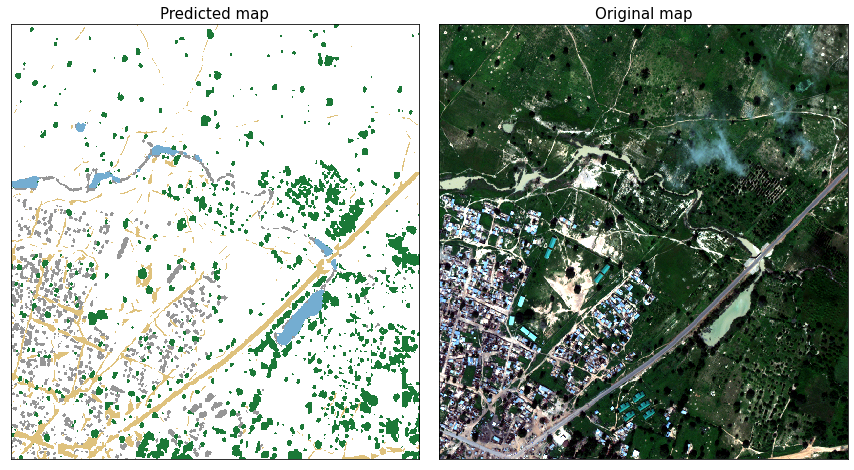

In [45]:
#@title Display prediction and original
fig, ax = plt.subplots(1,2,figsize=(15,8))
ax[0].imshow(land_map.transpose([1,2,0]), interpolation='nearest', aspect='auto')
ax[1].imshow(img1_8_bit, interpolation='nearest', aspect='auto')
ax[0].axes.xaxis.set_visible(False)
ax[0].axes.yaxis.set_visible(False)
ax[1].axes.xaxis.set_visible(False)
ax[1].axes.yaxis.set_visible(False)
ax[0].set_title("Predicted map",fontsize=15)
ax[1].set_title("Original map",fontsize=15)
plt.subplots_adjust(hspace=0.05,wspace=0.05)
plt.savefig('result.png')
plt.show()

In [53]:
#@title Prediction on a trained image
img1 = normalize(tiff.imread(MAIN_DIR+'mband/{}.tif'.format(TEST_IMAGE1)).transpose([1,2,0]))
prediction = predict(img1,model,patch_sz=PATCH_SZ).transpose([2,0,1])

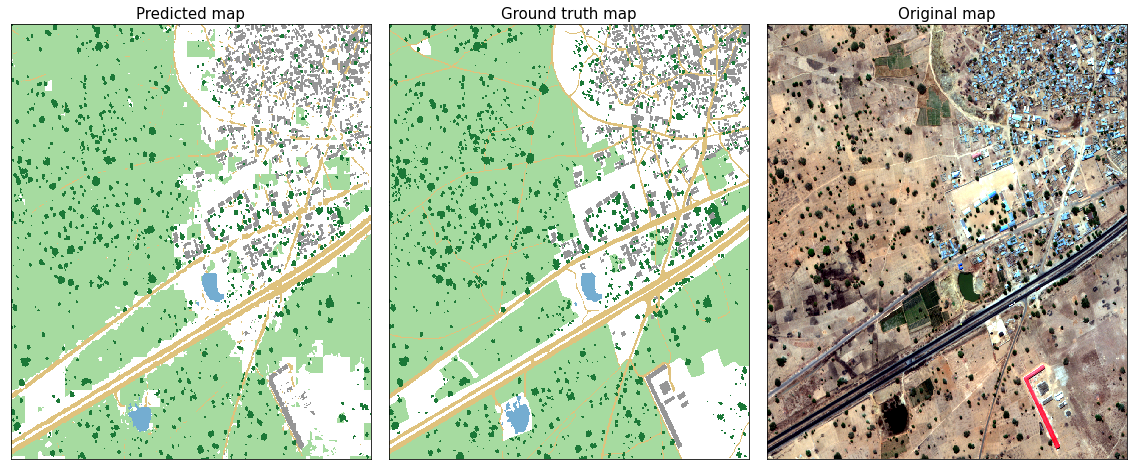

In [52]:
#@title Display prediction on trained image
gt_img = tiff.imread(MAIN_DIR+'gt_mband/{}.tif'.format(TEST_IMAGE1))/255
land_map1 = picture_from_mask(prediction,0.5)
gt_land_map = picture_from_mask(gt_img,0.5)
img2_8_bit = visualize(MAIN_DIR+'mband/{}.tif'.format(TEST_IMAGE1))
fig, ax = plt.subplots(1,3,figsize=(20,8))
ax[0].imshow(land_map1.transpose([1,2,0]), interpolation='nearest', aspect='auto')
ax[1].imshow(gt_land_map.transpose([1,2,0]), interpolation='nearest', aspect='auto')
ax[2].imshow(img2_8_bit, interpolation='nearest', aspect='auto')
ax[0].axes.xaxis.set_visible(False)
ax[0].axes.yaxis.set_visible(False)
ax[1].axes.xaxis.set_visible(False)
ax[1].axes.yaxis.set_visible(False)
ax[2].axes.xaxis.set_visible(False)
ax[2].axes.yaxis.set_visible(False)
ax[0].set_title("Predicted map",fontsize=15)
ax[1].set_title("Ground truth map",fontsize=15)
ax[2].set_title("Original map",fontsize=15)
plt.subplots_adjust(hspace=0.05,wspace=0.05)
plt.savefig('result1.png')
plt.show()